In [1]:
import sys
import os
sys.path.append("../../libraries/pvae/")
from pvae.manifolds.poincareball import PoincareBall
from pvae.manifolds.euclidean import Euclidean
from pvae.models.architectures import EncWrapped, DecWrapped
from pvae.distributions.wrapped_normal import WrappedNormal
from pvae.distributions.riemannian_normal import RiemannianNormal
from pvae.ops.manifold_layers import GeodesicLayer
from pvae.objectives import vae_objective
from torch.distributions.normal import Normal
sys.path.append("../../libraries/")
from HypHC.optim.radam import RAdam
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.linkage import nn_merge_uf_fast_np, sl_from_embeddings
from HypHC.utils.metrics import dasgupta_cost
sys.path.append("../hyperLAI")
import math
import torch
import torchvision
from torchvision import transforms
from torch import nn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from models.hyperbolic_hc_loss import HyperbolicHCLoss
from models.encoder_decoder_architectures import *
from models.vae_model import vae_model
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset
from torch.optim import Adam
from utils.sim_funcs import sim_func_dict
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model

enc_dec_dict = {"fc_wrapped_encoder": fc_wrapped_encoder, "fc_wrapped_decoder": fc_wrapped_decoder, "fc_geodesic_decoder": fc_geodesic_decoder} 
manifold_dict = {"PoincareBall": PoincareBall, "Euclidean": Euclidean}
distribution_dict = {"WrappedNormal": WrappedNormal, "Normal": Normal, "RiemannianNormal": RiemannianNormal}


# Load Model and Obtain Embeddings

In [2]:
model_dir = "/scratch/users/patelas/hyperLAI/models/vae_models/scratch/mnist/runs_100epochs/twolayers_lrnegtwo_tempnegfive_hc1000_recon100k/"
args = read_config(model_dir + "mnist_vae_config.json")

In [3]:
flat_trans = transforms.Lambda(lambda x: x.flatten())
mnist_train = torchvision.datasets.MNIST(root=args["mnist_root"], train=True, download=False, 
                                         transform=transforms.Compose([transforms.ToTensor(), flat_trans]))
test_final = torchvision.datasets.MNIST(root=args["mnist_root"], train=False, download=False, 
                                    transform=transforms.Compose([transforms.ToTensor(), flat_trans]),
                                     target_transform=transforms.Compose([transforms.ToTensor()]))
tv_final, others = torch.utils.data.random_split(mnist_train, [args["train_size"] + args["valid_size"], 60000 - args["train_size"] - args["valid_size"]], 
                                                 generator=torch.Generator().manual_seed(0))
train_final, valid_final = torch.utils.data.random_split(tv_final, [args["train_size"], args["valid_size"]], 
                                                         generator=torch.Generator().manual_seed(0))
print(len(train_final), len(valid_final))
print(train_final[0][1], valid_final[0][1])
train_loader = DataLoader(train_final, batch_size=args["batch_size"])
valid_loader = DataLoader(valid_final, batch_size=args["batch_size"])


30000 5000
6 9


In [4]:
manifold = manifold_dict[args["manifold"]](args["embedding_size"])
enc_type, dec_type  = enc_dec_dict[args["enc_type"]], enc_dec_dict[args["dec_type"]]
encoder = enc_type(manifold, train_final[0][0].shape[-1], args["num_encoder_int_layers"], 
                   args["encoder_int_layer_sizes"], args["encoder_dropout_vals"], args["embedding_size"])
decoder = dec_type(manifold, train_final[0][0].shape[-1], args["num_decoder_int_layers"], 
                   args["decoder_int_layer_sizes"], args["decoder_dropout_vals"], args["embedding_size"])

model = vae_model(encoder, decoder, manifold, distribution_dict[args["posterior_dist"]],
                  distribution_dict[args["prior_dist"]], args["prior_mean"], args["prior_std"], args["temperature"], 
                  args["init_size"], args["min_scale"], args["max_scale"])


In [5]:
model_info = torch.load("%smodel.pt"%(model_dir))
model.load_state_dict(model_info["model_state"])

<All keys matched successfully>

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
numbers, labels, embeddings, recons = [], [], [], []
with torch.no_grad():
    for i, (num, lab) in enumerate(valid_loader):
        embs = model.embed(num.float().to(device))
        numbers.append(num.cpu())
        embeddings.append(embs.cpu())
        labels.append(lab.cpu())
        recon = model.generate(embs.to(device))
        recons.append(recon.cpu())


In [7]:
numbers = torch.cat(numbers).numpy()
embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()
recons = torch.cat(recons).numpy()

# Plot Node Embeddings (Perhaps as PCA)

In [8]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot embeddings. Uncomment/comment as necessary depending on if you want raw embeddings or PCA
    '''
#     weights_pca = PCA().fit_transform(embeddings)
#     scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    scplot = sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.title("PCA of Embedding Weights")
    plt.xlabel("Embedding 1")
    plt.ylabel("Embedding 2")
    plt.title("Embedding Weights")

    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if annotations[line] != "Hazara":
#                 continue
            scplot.text(embeddings[line,0]+0.001, embeddings[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


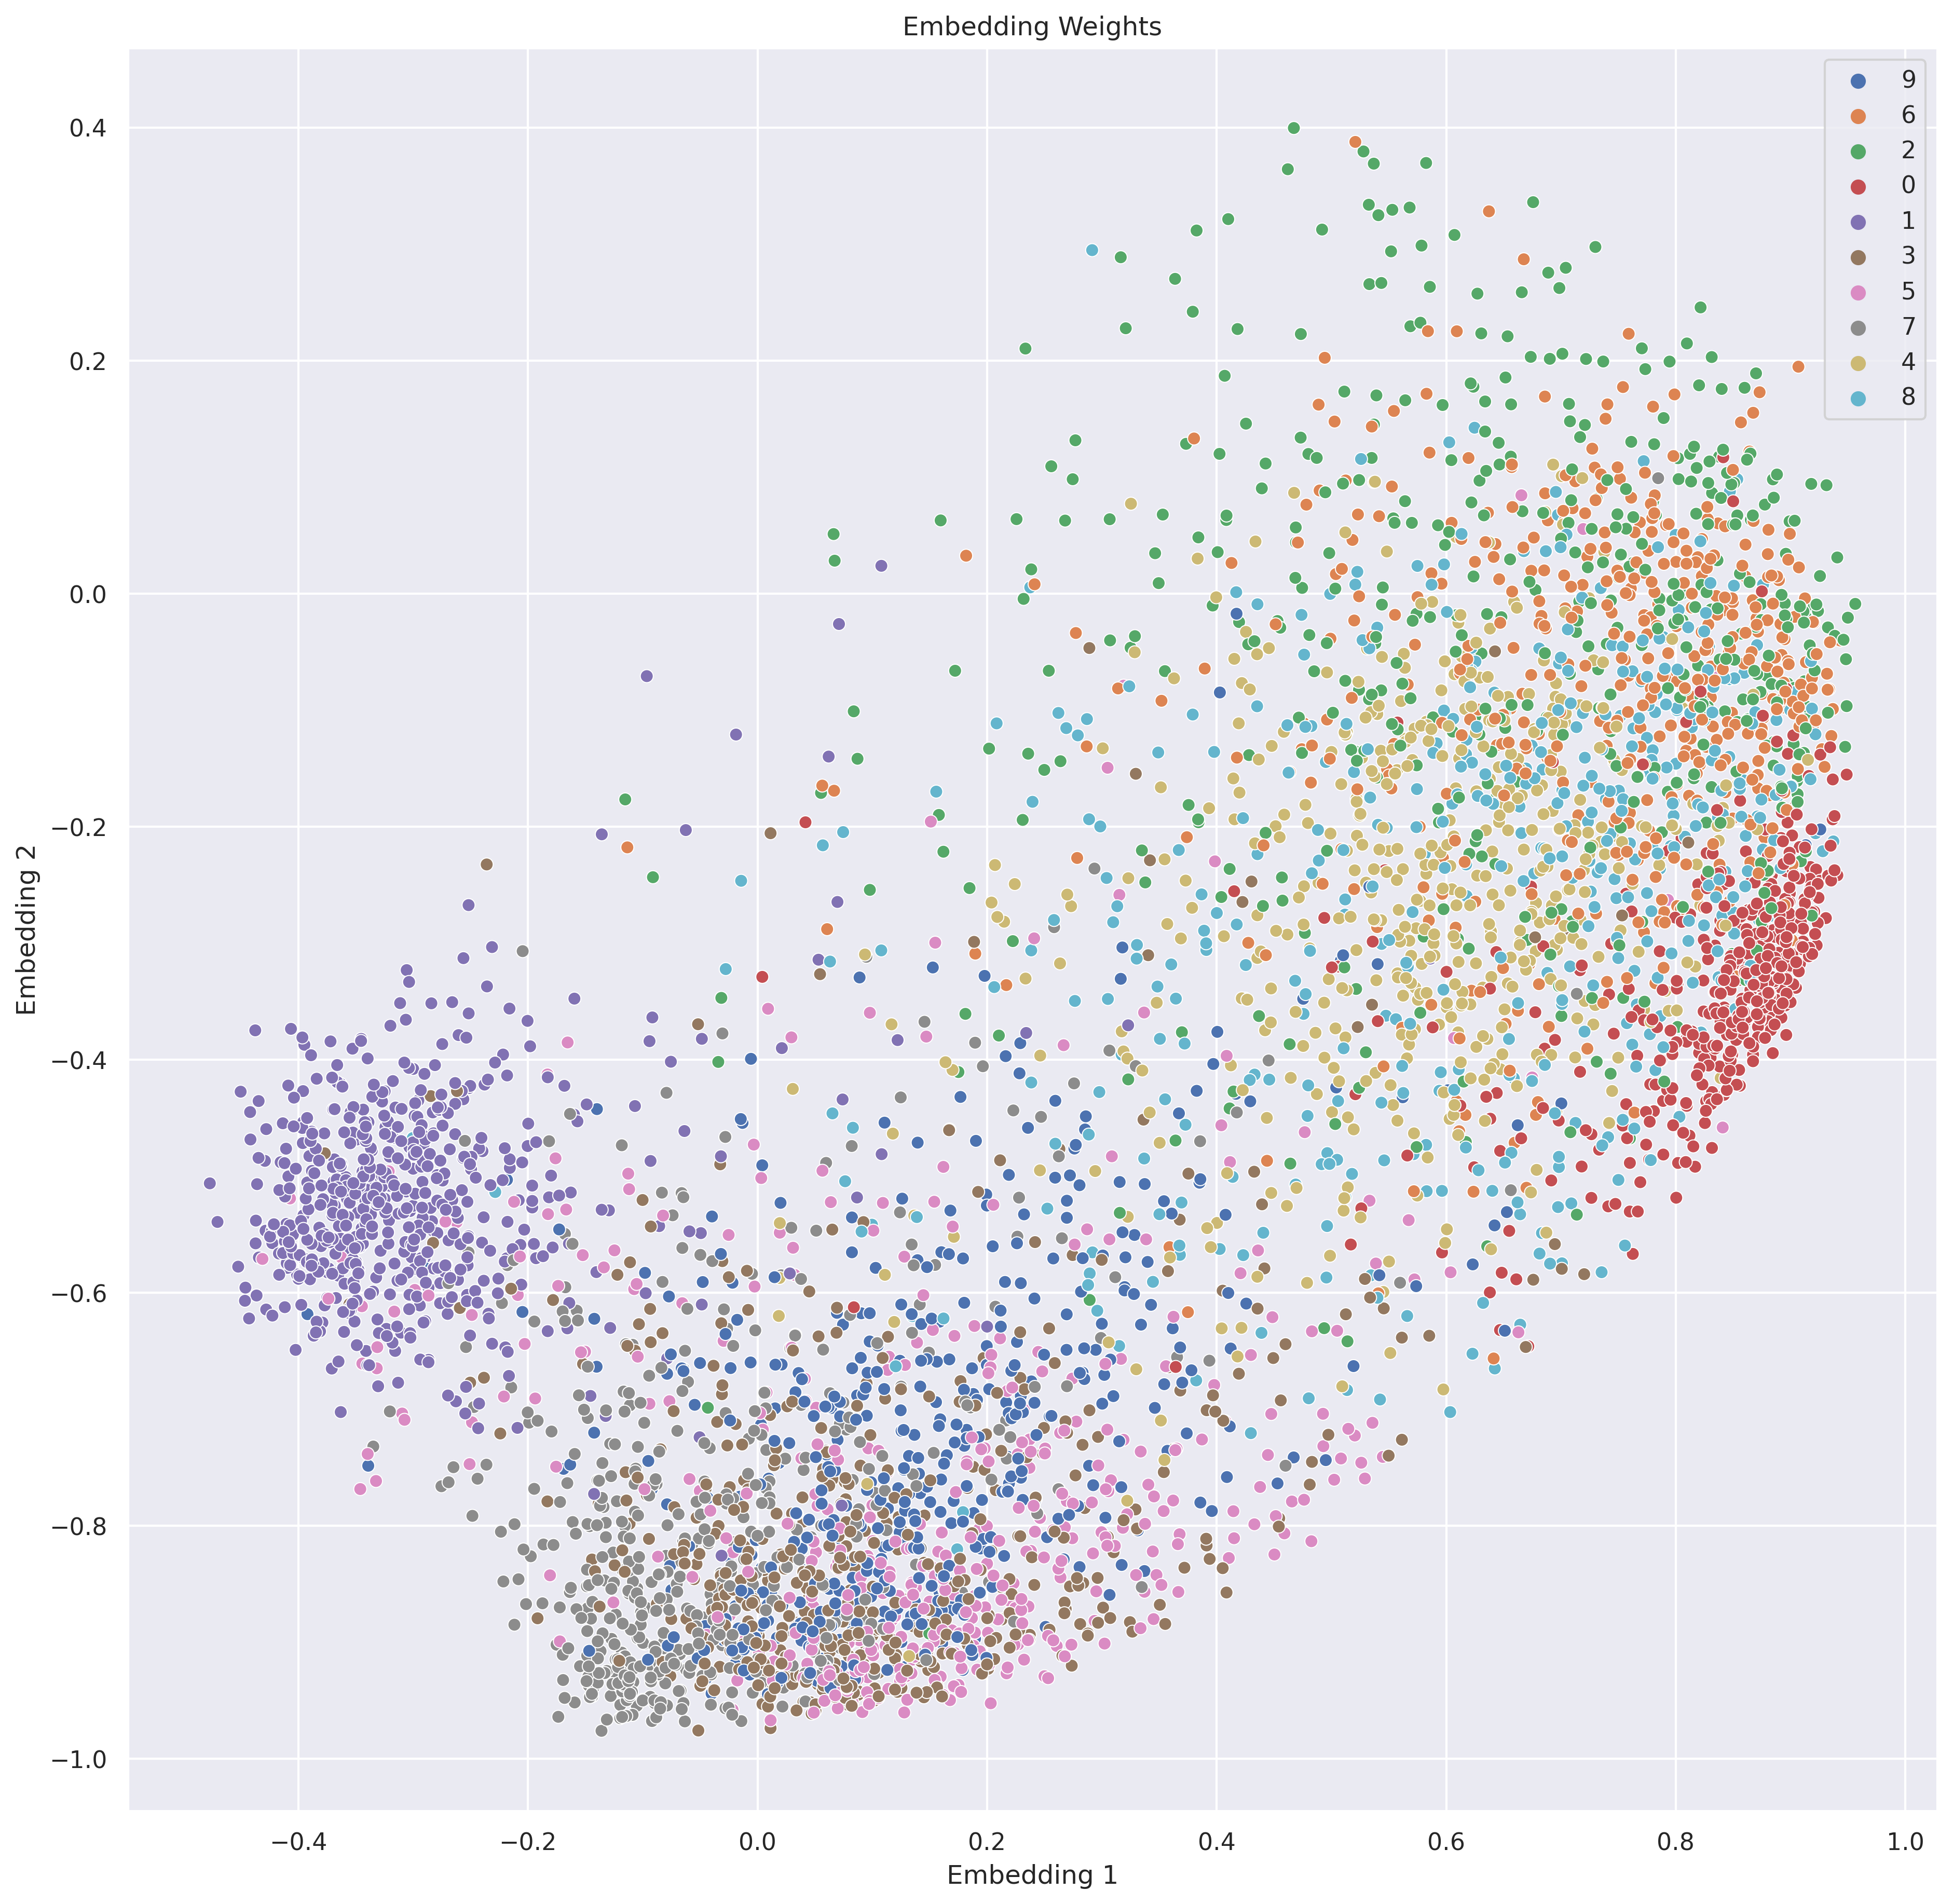

In [9]:
plt.figure(figsize=[15, 15], dpi=300)
plot_weights_pca(embeddings, [str(x) for x in labels])
plt.show()

# Produce, Plot, and Evaluate Tree

In [10]:
def decode_tree(model, embeddings, device, fast_decoding):
    """Build a binary tree (nx graph) from leaves' embeddings. Assume points are normalized to same radius."""
    with torch.no_grad():
        leaves_embeddings = model.HypHCLoss.normalize_embeddings(torch.tensor(embeddings).to(device))
        leaves_embeddings = project(leaves_embeddings).cpu()
    sim_fn = lambda x, y: torch.sum(x * y, dim=-1)
    if fast_decoding:
        parents = nn_merge_uf_fast_np(leaves_embeddings, S=sim_fn, partition_ratio=1.2)
    else:
        parents = sl_from_embeddings(leaves_embeddings, sim_fn)
    tree = nx.DiGraph()
    for i, j in enumerate(parents[:-1]):
        tree.add_edge(j, i)
    return tree


../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

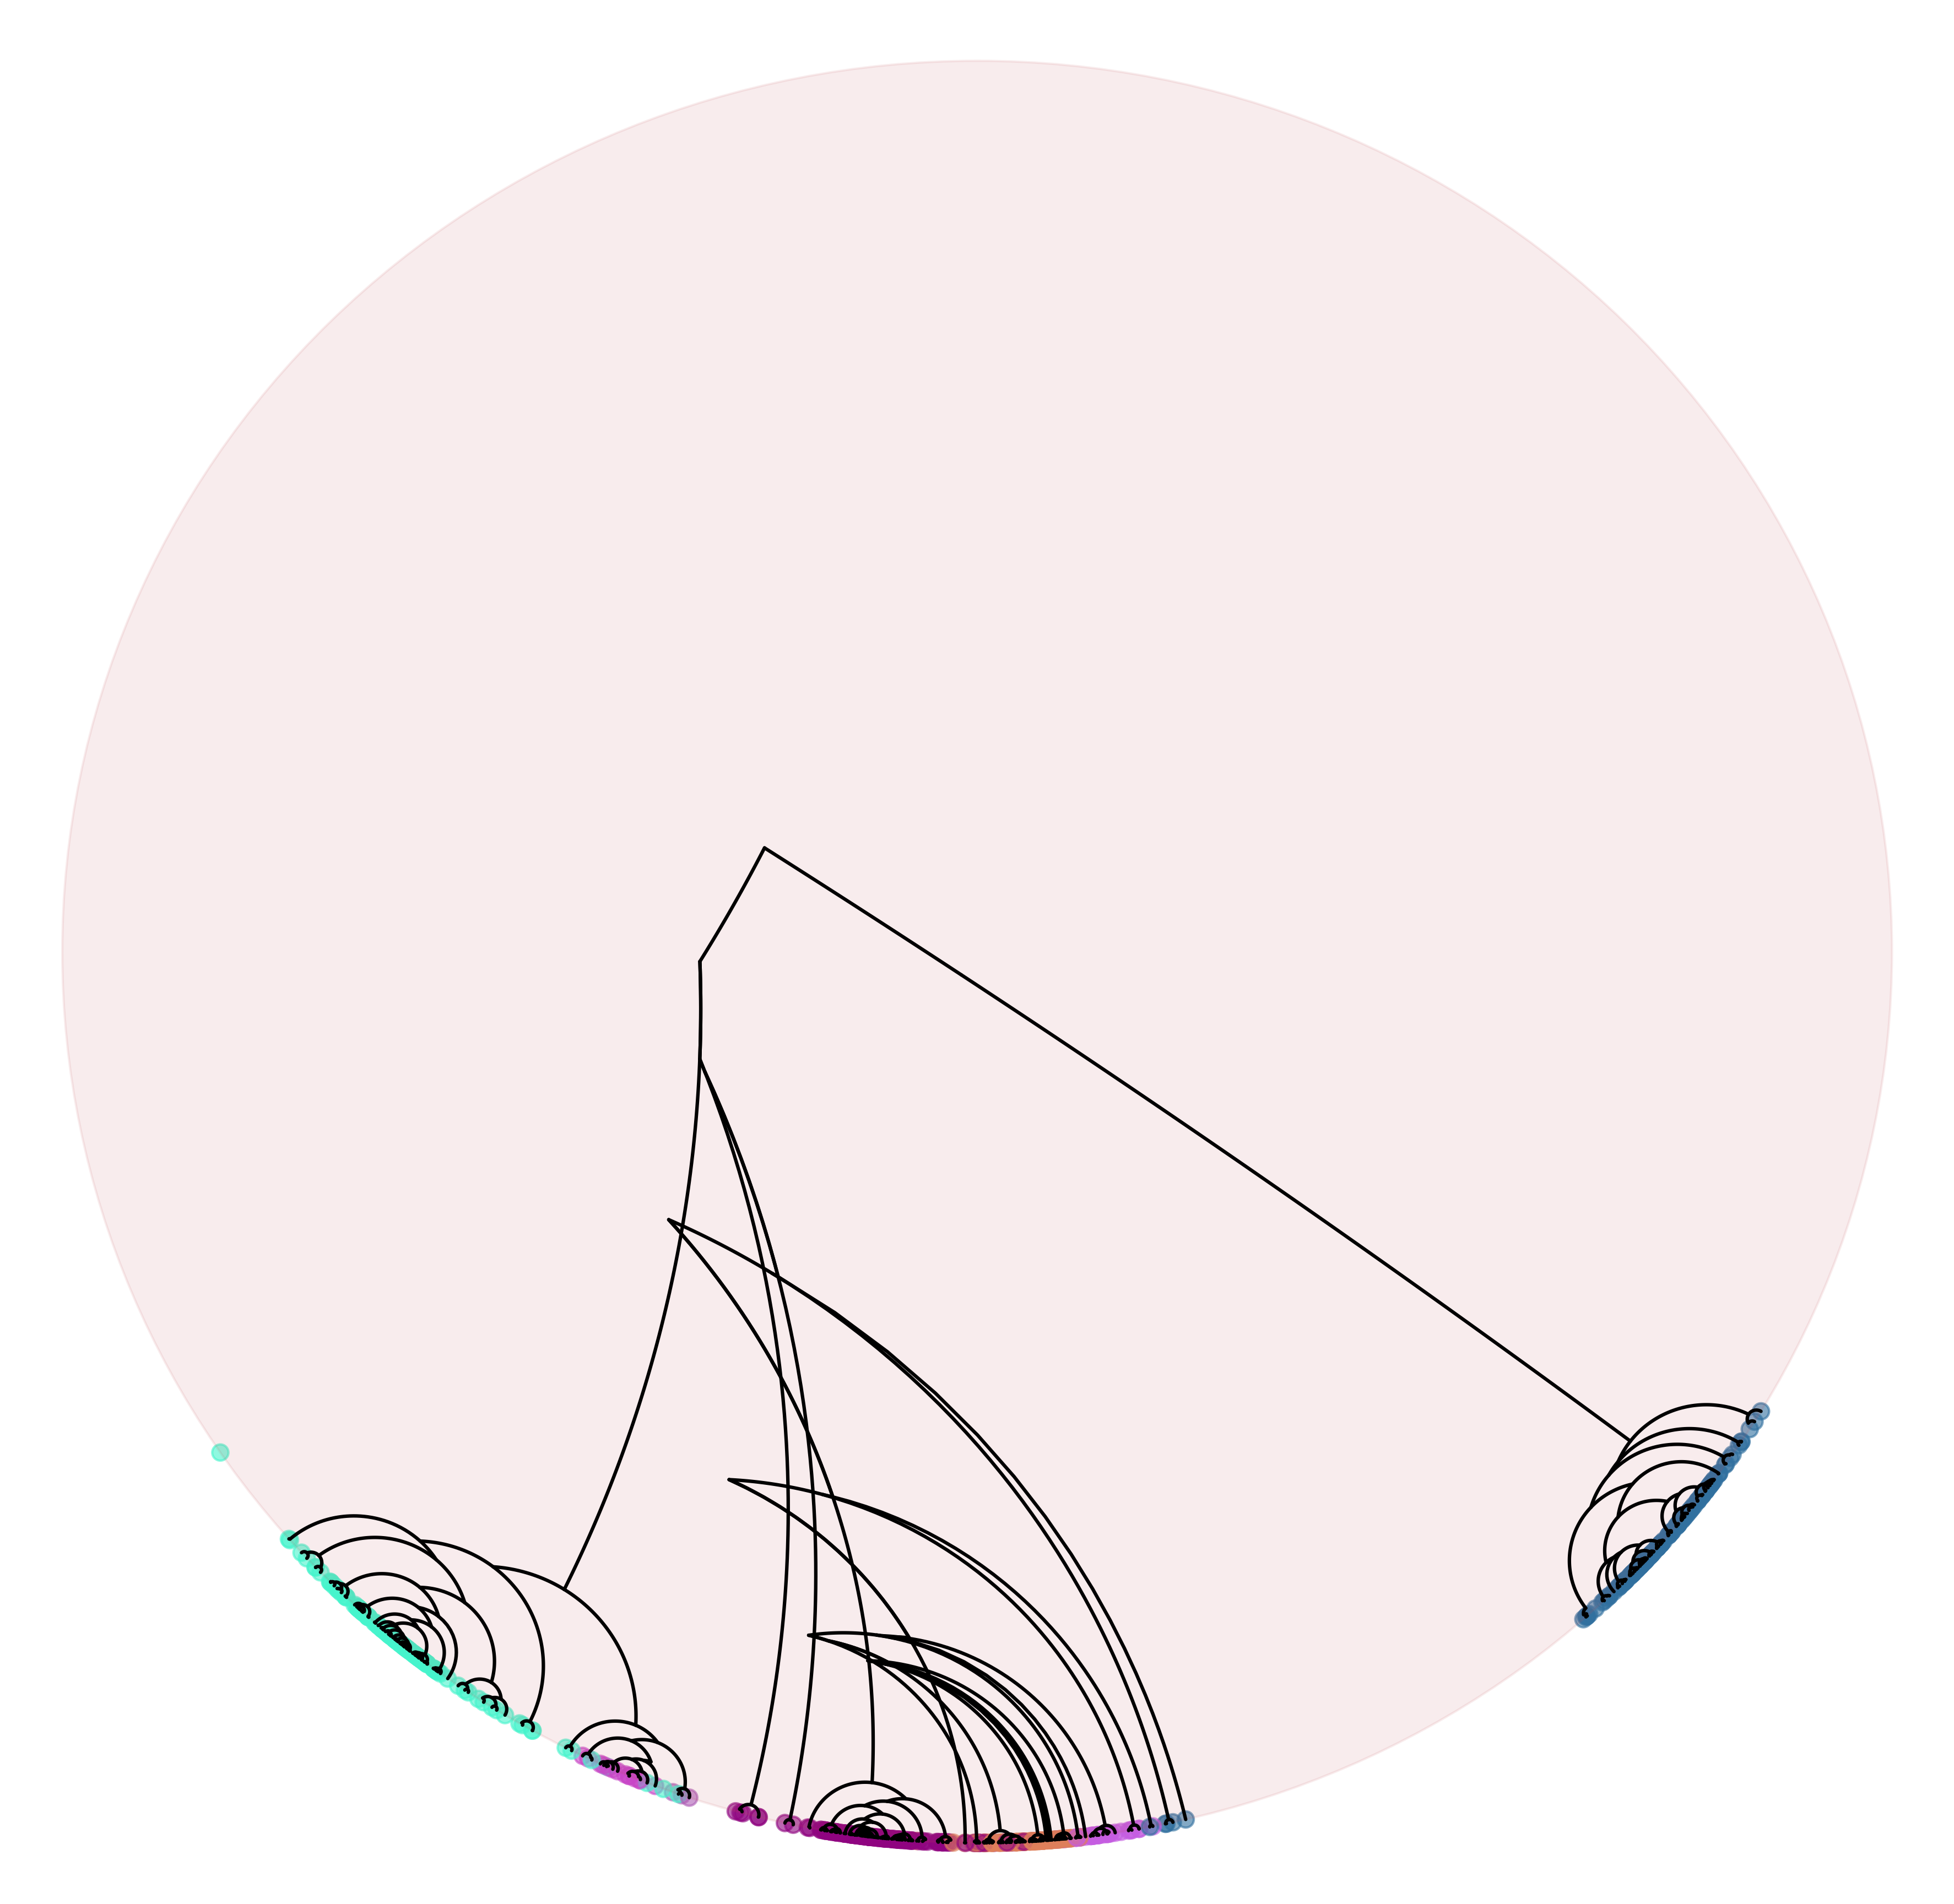

In [11]:
#Plot tree
embs_tree = embeddings
# embs_tree = PCA().fit_transform(embeddings)[:,:2]
tree = decode_tree(model, embs_tree, device, True)
with torch.no_grad():
    embs_normed = model.HypHCLoss.normalize_embeddings(torch.tensor(embs_tree).to(device))
    leaves_embeddings = project(embs_normed).cpu().numpy()
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = fig.add_subplot(111)
ax = plot_tree_from_leaves(ax, tree, leaves_embeddings * 100, labels=sp_full)
# for line in range(len(labels)):
#     ax.text(leaves_embeddings[line,0] * 100 +0.001, leaves_embeddings[line,1] * 100, 
#                  labels[line], ha='left', 
#             color='black', va="baseline", rotation=45, size=8)

plt.show()
